In [258]:
from pydataset import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import scipy.stats as st
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, precision_score, recall_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LR
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [259]:
df = data('mtcars')

In [260]:
df.sample(5)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Lotus Europa,30.4,4,95.1,113,3.77,1.513,16.90,1,1,5,2
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
Merc 450SL,17.3,8,275.8,180,3.07,3.730,17.60,0,0,3,3
Pontiac Firebird,19.2,8,400.0,175,3.08,3.845,17.05,0,0,3,2
Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [261]:
random_categories = np.random.choice(['CategoryA', 'CategoryB', 'CategoryC'], size=len(df))
random_color = np.random.choice(['rojo', 'azul'], size=len(df))

# Add the array as a new column to the DataFrame
df['Random_Category'] = random_categories
df['Random_color'] = random_color

# Exploratory data analysis

In [262]:
df.describe()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.0000
mean,20.090625,6.187500,230.721875,146.687500,3.596563,3.217250,17.848750,0.437500,0.406250,3.687500,2.8125
std,6.026948,1.785922,123.938694,68.562868,0.534679,0.978457,1.786943,0.504016,0.498991,0.737804,1.6152
min,10.400000,4.000000,71.100000,52.000000,2.760000,1.513000,14.500000,0.000000,0.000000,3.000000,1.0000
25%,15.425000,4.000000,120.825000,96.500000,3.080000,2.581250,16.892500,0.000000,0.000000,3.000000,2.0000
50%,19.200000,6.000000,196.300000,123.000000,3.695000,3.325000,17.710000,0.000000,0.000000,4.000000,2.0000
75%,22.800000,8.000000,326.000000,180.000000,3.920000,3.610000,18.900000,1.000000,1.000000,4.000000,4.0000
max,33.900000,8.000000,472.000000,335.000000,4.930000,5.424000,22.900000,1.000000,1.000000,5.000000,8.0000


In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mpg              32 non-null     float64
 1   cyl              32 non-null     int64  
 2   disp             32 non-null     float64
 3   hp               32 non-null     int64  
 4   drat             32 non-null     float64
 5   wt               32 non-null     float64
 6   qsec             32 non-null     float64
 7   vs               32 non-null     int64  
 8   am               32 non-null     int64  
 9   gear             32 non-null     int64  
 10  carb             32 non-null     int64  
 11  Random_Category  32 non-null     object 
 12  Random_color     32 non-null     object 
dtypes: float64(5), int64(6), object(2)
memory usage: 3.5+ KB


In [264]:
#Function that takes df, and returns: cols and rows,duplicated rows, missing values
def intro_df(df):
    print('Number of rows and columns:', df.shape)
    print('Number of duplicated rows:', df.duplicated().sum())
    print('Number of missing values:', df.isnull().sum().sum())
    
    print("-----------------------------------")
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    print('Numeric columns:', list(numeric_columns))
    categorical_columns = df.select_dtypes(include=[object]).columns
    print('Categorical columns:', list(categorical_columns))
    
    print("-----------------------------------")
    
    if df.isnull().sum().sum() > 0:
        print('Columns with missing values:', df.isnull().sum())
    if df.duplicated().sum() > 0:
        print('Duplicated rows:', df[df.duplicated()])
        
    print("-----------------------------------")
        
    return numeric_columns, categorical_columns

In [265]:
intro_df(df)

Number of rows and columns: (32, 13)
Number of duplicated rows: 0
Number of missing values: 0
-----------------------------------
Numeric columns: ['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']
Categorical columns: ['Random_Category', 'Random_color']
-----------------------------------
-----------------------------------


(Index(['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear',
        'carb'],
       dtype='object'),
 Index(['Random_Category', 'Random_color'], dtype='object'))

## Outliers

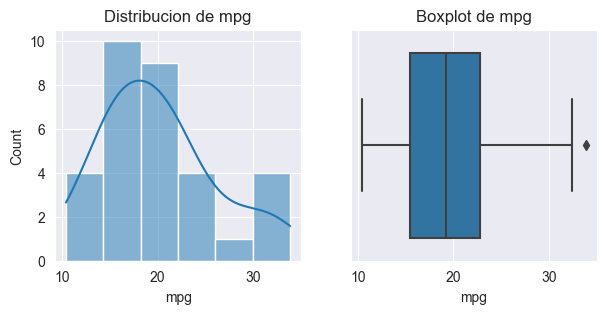

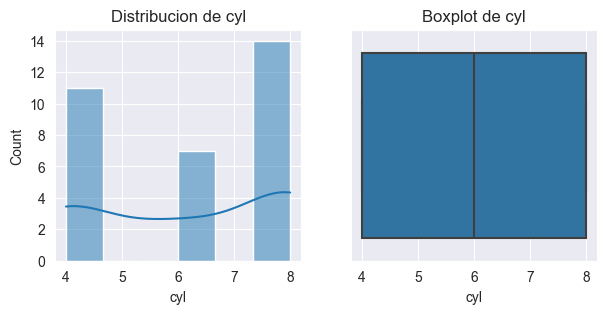

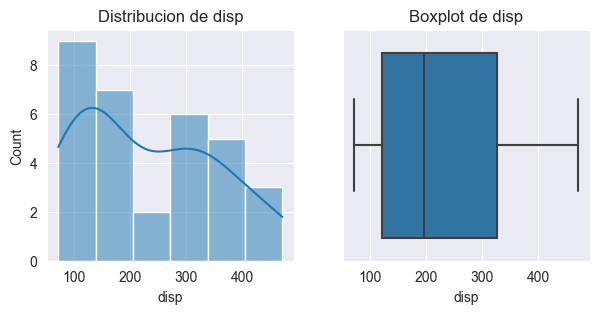

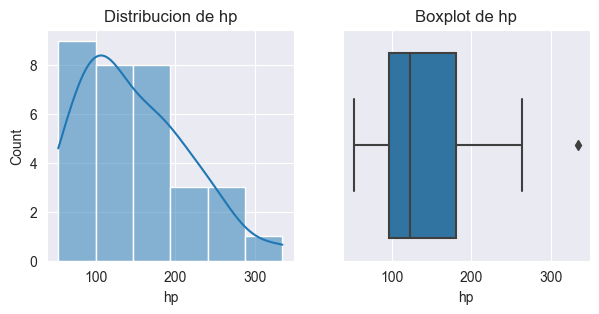

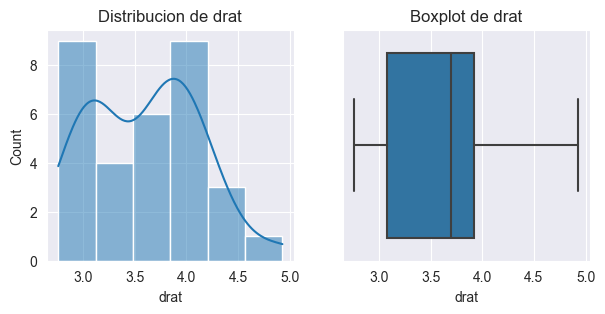

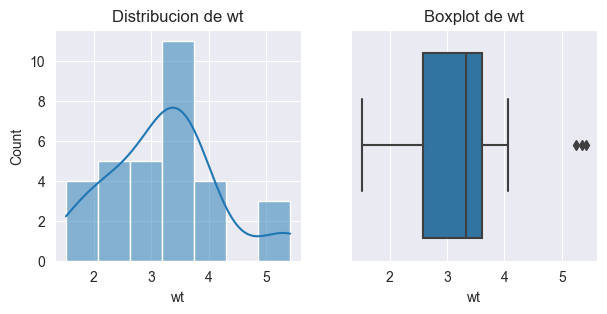

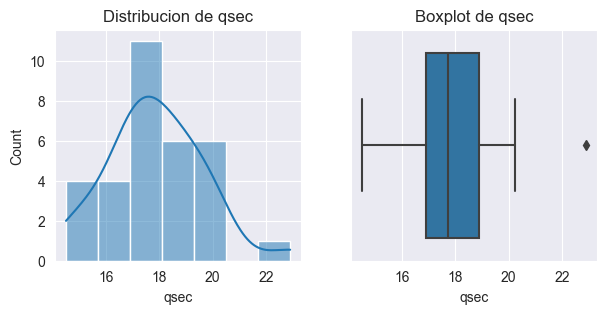

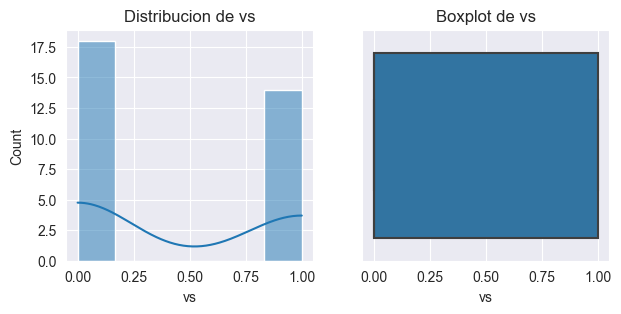

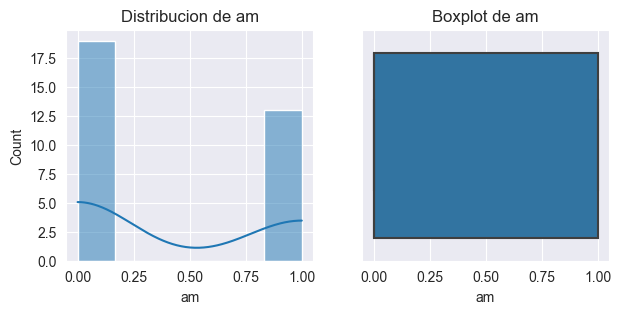

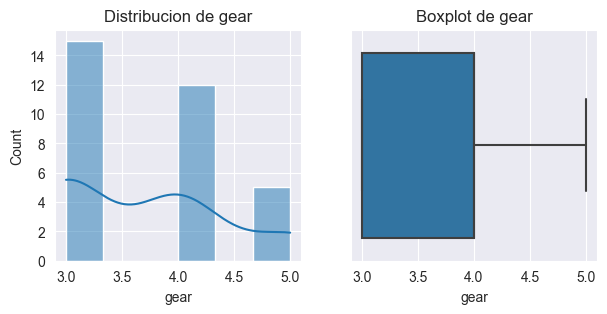

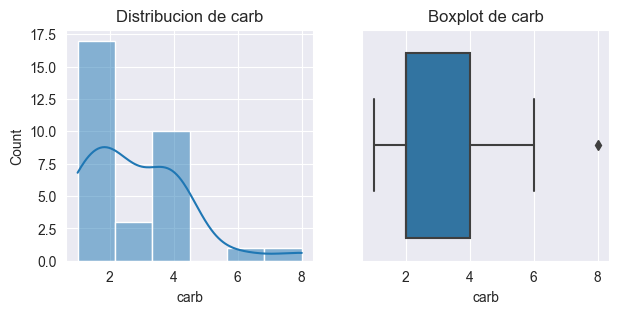

In [266]:
def distr_values(variable):
    fig, ax = plt.subplots(1,2, figsize=(7,3))

    ax[0].set_title(f"Distribucion de {variable}")
    sns.histplot(data = df, x = f"{variable}", kde = True, ax = ax[0])

    ax[1].set_title(f"Boxplot de {variable}")
    sns.boxplot(data=df, x = f"{variable}", ax = ax[1])
    
#apply distr_values to all numerical columns
for col in df.select_dtypes(include=[np.number]).columns:
    distr_values(col)

In [267]:
def outliers_check_2(data, column):
    top_max_values = data.nlargest(2, column)[column].values
    top_min_values = data.nsmallest(2, column)[column].values
    return print("The Top 2 Max", column, "are: ", top_max_values, "and the Top 2 Min", column, "are:", top_min_values)
#Chequear outliers en caso de que haya

## Correlation

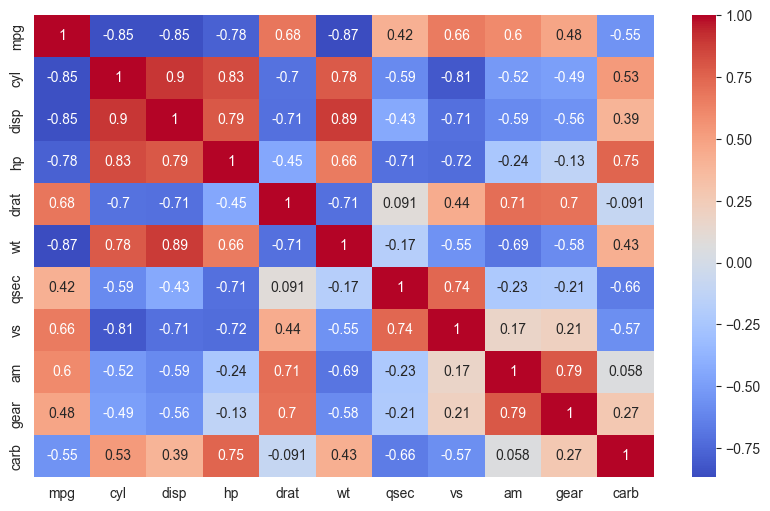

In [268]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include = [np.number]).corr(), annot=True, cmap='coolwarm')
plt.show()

## Countplot for all categorical columns
En caso de que haya variable target, discriminar por target

In [269]:
#make sns_countplot for all categorical columns
def sns_countplot(df, target):
    for col in df.select_dtypes(include=[object]).columns:
        plt.figure(figsize=(5,3))
        if target == None:
            sns.countplot(data=df, x=col, order = df[col].value_counts().index)
        else:#smaller
            sns.countplot(data=df, x=col, hue=target, order = df[col].value_counts().index)
            plt.show()

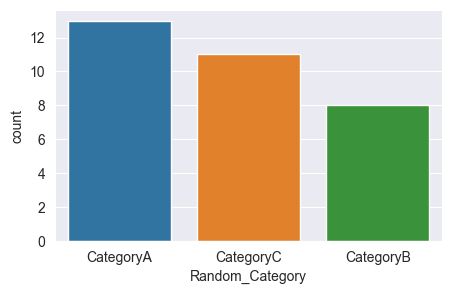

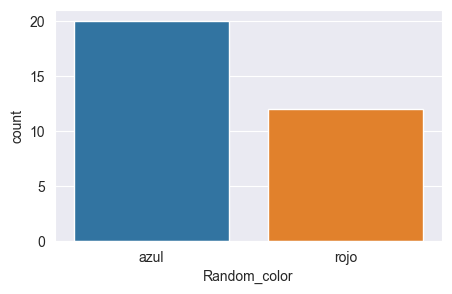

In [270]:
sns_countplot(df, None)

In [271]:
#TEst total
df.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,Random_Category,Random_color
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,CategoryA,azul
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,CategoryA,azul
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,CategoryC,rojo
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,CategoryB,rojo
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,CategoryA,azul


In [272]:
#pipeline. Onehotencode some columns, ordinal encode others, and std scale numerical. Then apply logistic regression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_selector

df['target'] = np.random.choice([0,1], size=len(df))

X = df.drop(columns = 'target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), ['Random_Category']),
        ('ordinal', OrdinalEncoder(), ['Random_color']),
        ('scaler', StandardScaler(), X.select_dtypes(include=[np.number]).columns)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('logistic', LogisticRegression())])

#RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions = {'logistic__C': uniform(loc=0, scale=4),
                       'logistic__penalty': ['l1', 'l2']}

clf = RandomizedSearchCV(pipeline, param_distributions, n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('onehot',
                                                                               OneHotEncoder(),
                                                                               ['Random_Category']),
                                                                              ('ordinal',
                                                                               OrdinalEncoder(),
                                                                               ['Random_color']),
                                                                              ('scaler',
                                                                               StandardScaler(),
                                                                               Index(['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear',
       'carb'],
      dtype='object'))])),
                                             ('logistic',
                                              LogisticRegression())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'logistic__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000275FD4D0790>,
                                        'logistic__penalty': ['l1', 'l2']},
                   random_state=42, verbose=1)

In [273]:
pd.DataFrame(preprocessor.fit_transform(X_train), columns = preprocessor.get_feature_names_out())

,onehot__Random_Category_CategoryA,onehot__Random_Category_CategoryB,onehot__Random_Category_CategoryC,ordinal__Random_color,scaler__mpg,scaler__cyl,scaler__disp,scaler__hp,scaler__drat,scaler__wt,scaler__qsec,scaler__vs,scaler__am,scaler__gear,scaler__carb
0,1.0,0.0,0.0,1.0,1.226397,-1.212336,-1.260864,-1.218108,0.864744,-1.262346,0.734904,1.128152,1.224745,0.577350,-1.298813
1,0.0,1.0,0.0,0.0,-0.493173,1.032730,0.408975,0.648348,-0.944269,0.614776,-0.150359,-0.886405,-0.816497,-0.866025,0.410152
2,1.0,0.0,0.0,0.0,0.143068,-0.089803,-0.573583,-0.497722,0.542346,-0.546007,-0.926666,-0.886405,1.224745,0.577350,1.264634
3,1.0,0.0,0.0,0.0,-0.252433,1.032730,1.123407,0.566486,-0.800981,0.311508,-0.545322,-0.886405,-0.816497,-0.866025,-0.444331
4,1.0,0.0,0.0,1.0,-0.940261,1.032730,1.802203,1.466969,-0.657693,2.303662,-0.272933,-0.886405,-0.816497,-0.866025,1.264634
5,0.0,0.0,1.0,0.0,-0.355607,-0.089803,-0.022061,-0.579584,-1.499511,0.332423,1.633787,1.128152,-0.816497,-0.866025,-1.298813
6,0.0,0.0,1.0,1.0,-0.854282,1.032730,0.408975,0.648348,-0.944269,0.667063,0.122030,-0.886405,-0.816497,-0.866025,0.410152
7,0.0,1.0,0.0,0.0,-0.647934,1.032730,0.408975,0.648348,-0.944269,0.970331,-0.286553,-0.886405,-0.816497,-0.866025,0.410152
8,0.0,0.0,1.0,1.0,-1.181000,1.032730,1.038558,1.712556,0.237858,0.729808,-1.641686,-0.886405,-0.816497,-0.866025,1.264634
9,1.0,0.0,0.0,0.0,0.143068,-0.089803,-0.573583,-0.497722,0.542346,-0.279341,-0.545322,-0.886405,1.224745,0.577350,1.264634


In [274]:
clf.best_params_

{'logistic__C': 1.3348344445560874, 'logistic__penalty': 'l2'}

In [275]:
def evaluate_both_train_and_test(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Train')
    print('Precision:', precision_score(y_train, y_train_pred))
    print('Recall:', recall_score(y_train, y_train_pred))
    print('F1:', f1_score(y_train, y_train_pred))
    print('ROC AUC:', roc_auc_score(y_train, y_train_pred))
    
    print('Test')
    print('Precision:', precision_score(y_test, y_test_pred))
    print('Recall:', recall_score(y_test, y_test_pred))
    print('F1:', f1_score(y_test, y_test_pred))
    print('ROC AUC:', roc_auc_score(y_test, y_test_pred))
    
    return y_train_pred, y_test_pred

y_train_pred, y_test_pred = evaluate_both_train_and_test(clf, X_train, X_test, y_train, y_test)

Train
Precision: 0.7857142857142857
Recall: 0.8461538461538461
F1: 0.8148148148148148
ROC AUC: 0.798076923076923
Test
Precision: 0.6666666666666666
Recall: 0.4
F1: 0.5
ROC AUC: 0.44999999999999996


# Modelos

## Encoding

Chequear si no hay categoricas ordinales

In [276]:
X = df.drop(columns = 'Random_color')
y = df['Random_color']



df_categorical = X.select_dtypes(include=[object])

onehotencoder = OneHotEncoder()
df_encoded = onehotencoder.fit_transform(df_categorical).toarray()
feature_names = onehotencoder.get_feature_names_out(df_categorical.columns)

df_encoded = pd.DataFrame(df_encoded, columns = feature_names)
df_encoded.index = df.index

In [277]:
#concatenate the encoded columns to the original dataframe
df = pd.concat([df, df_encoded], axis=1)
df = df.drop(columns = df_categorical.columns)

## Regresion

In [278]:
X = df.drop(columns = ['mpg', 'Random_color'])
y = df['mpg']

In [279]:
#Definimos el modelo
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

#Definimos el pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('regressor', linear)])

#Definimos los parámetros
parameters = {'selector__k': [1, 2, 5, 7, 10]}

#Realizamos la validación cruzada Gridsearch para encontrar el mejor valor de C
grid = GridSearchCV(pipe, parameters, cv=5, scoring='r2')
grid.fit(X, y)

#Obtenemos los mejores parametros y el modelo con ese valor
best_params = grid.best_params_
best_model = grid.best_estimator_

best_params

{'selector__k': 2}

In [280]:
# Evaluamos el modelo en train y calculamos el R2
from sklearn.metrics import r2_score
y_pred = best_model.predict(X)
r2 = r2_score(y, y_pred)
r2

0.8267854518827915

## Clasificacion

### Balanceo

In [281]:
prop = df["Random_color"].value_counts(normalize=True)

In [282]:
from scipy.stats import multivariate_normal, norm

expected_frequency = 1/len(np.unique(df["Random_color"]))

#Calculamos la desviación estandar de cada categoría
std_errors = np.sqrt(prop*(1-prop)/len(df["Random_color"]))

#Caculamos el p-value para cada categoría:
for target_val in prop.index:
  z = (prop[target_val] - expected_frequency)/std_errors[target_val]
  print("Class:",target_val)
  print("p-value:",norm.cdf(-np.abs(z)))
  print("----")

Class: azul
p-value: 0.07206351740800766
----
Class: rojo
p-value: 0.07206351740800766
----


p-valor muy pequeño. EL dataset está desbalanceado
si esta desbalanceado, hay que aplicar y_stratify.

In [286]:
#Replace 'azul' with 1 and 'rojo' with 0
df['Random_color'] = df['Random_color'].replace({'azul': 1, 'rojo': 0})

X = df.drop(columns = 'Random_color')
y = df['Random_color']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=99)

In [287]:
def model_trial(model, parameters, smote = False, ros = False):

  np.random.seed(42)

  #Queremos asegurarnos de tener los mismos 5 splits de data cada vez.
  #Para lograr eso creamos un KFold object, kf, y lo pasamos como cv=kf en vez del normal cv=5.
  kf = StratifiedKFold(n_splits=5, shuffle=False)

  #Definimos un pipeline según corresponda
  if smote:
    pipe = Pipeline(steps=[('smote', SMOTE(random_state=42)), ('standardscaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', model)])

  elif ros:
    pipe = Pipeline(steps=[('ros', RandomOverSampler(random_state=42)), ('standardscaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', model)])

  else:
    pipe = Pipeline([('scaler', StandardScaler()), ('selector', SelectKBest(f_classif)), ('classifier', model)])


  # Realizamos la validación cruzada Gridsearch para encontrar el mejor valor de C
  grid = GridSearchCV(pipe, parameters, cv=kf, scoring='precision') #Buscamos maximizar el precision
  grid.fit(X_train, y_train)

  # Obtenemos los mejores parametros y el modelo con ese valor
  best_params = grid.best_params_
  best_model = grid.best_estimator_
  best_score = grid.best_score_

  # Evaluamos el modelo en train y calculamos el AUC-ROC, F1-score y Precision-Score

  y_train_pred = best_model.predict(X_train)
  auc_roc_train = roc_auc_score(y_train, y_train_pred)
  f1_train = f1_score(y_train, y_train_pred)
  precision_train = precision_score(y_train, y_train_pred)

  # Evaluamos el modelo en test y calculamos el AUC-ROC, F1-score y Precision-Score
  y_pred = best_model.predict(X_test)
  auc_roc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print(f"Mejores parámetros: {best_params}")
  print(f"AUC-ROC Train: {auc_roc_train} and AUC-ROC Test: {auc_roc}")
  print(f"F1-Score Train: {f1_train} and F1-Score Test: {f1}")
  print(f"Precision-Score Train: {precision_train} and Precision-Score Test: {precision}")

  return precision, auc_roc, f1, best_model, precision_train, auc_roc_train, f1_train

In [288]:
#Modelo 1: Logistic Regression
model = LR()
parameters = {'selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
precision, auc_roc, f1, best_model, precision_train, auc_roc_train, f1_train = model_trial(model, parameters)

Mejores parámetros: {'classifier__C': 1, 'selector__k': 6}
AUC-ROC Train: 0.8263888888888888 and AUC-ROC Test: 0.41666666666666663
F1-Score Train: 0.875 and F1-Score Test: 0.5
Precision-Score Train: 0.875 and Precision-Score Test: 0.5


In [289]:
#Modelo 2: Random Forest
model = RandomForestClassifier()
parameters = {'selector__k': [1, 5, 10], 'classifier__n_estimators': [10, 100, 500]}
precision, auc_roc, f1, best_model, precision_train, auc_roc_train, f1_train = model_trial(model, parameters)

Mejores parámetros: {'classifier__n_estimators': 10, 'selector__k': 5}
AUC-ROC Train: 1.0 and AUC-ROC Test: 0.5416666666666667
F1-Score Train: 1.0 and F1-Score Test: 0.6666666666666665
Precision-Score Train: 1.0 and Precision-Score Test: 0.6


# No supervisado

In [290]:
std_scaler = StandardScaler()

escalar = df[['mpg', 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec']]
df_escalado_clusters = pd.DataFrame(std_scaler.fit_transform(escalar))
df_escalado_clusters.columns = escalar.columns
df_escalado_clusters

,mpg,cyl,disp,hp,drat,wt,qsec
0,0.153299,-0.106668,-0.579750,-0.543655,0.576594,-0.620167,-0.789601
1,0.153299,-0.106668,-0.579750,-0.543655,0.576594,-0.355382,-0.471202
2,0.456737,-1.244457,-1.006026,-0.795570,0.481584,-0.931678,0.432823
3,0.220730,-0.106668,0.223615,-0.543655,-0.981576,-0.002336,0.904736
4,-0.234427,1.031121,1.059772,0.419550,-0.848562,0.231297,-0.471202
5,-0.335572,-0.106668,-0.046906,-0.617748,-1.589643,0.252064,1.348220
6,-0.976163,1.031121,1.059772,1.456847,-0.734549,0.366285,-1.142114
7,0.726459,-1.244457,-0.688779,-1.254944,0.177551,-0.028296,1.223135
8,0.456737,-1.244457,-0.737144,-0.765933,0.614599,-0.069830,2.871986
9,-0.150138,-0.106668,-0.517448,-0.351014,0.614599,0.231297,0.256567


## K-means

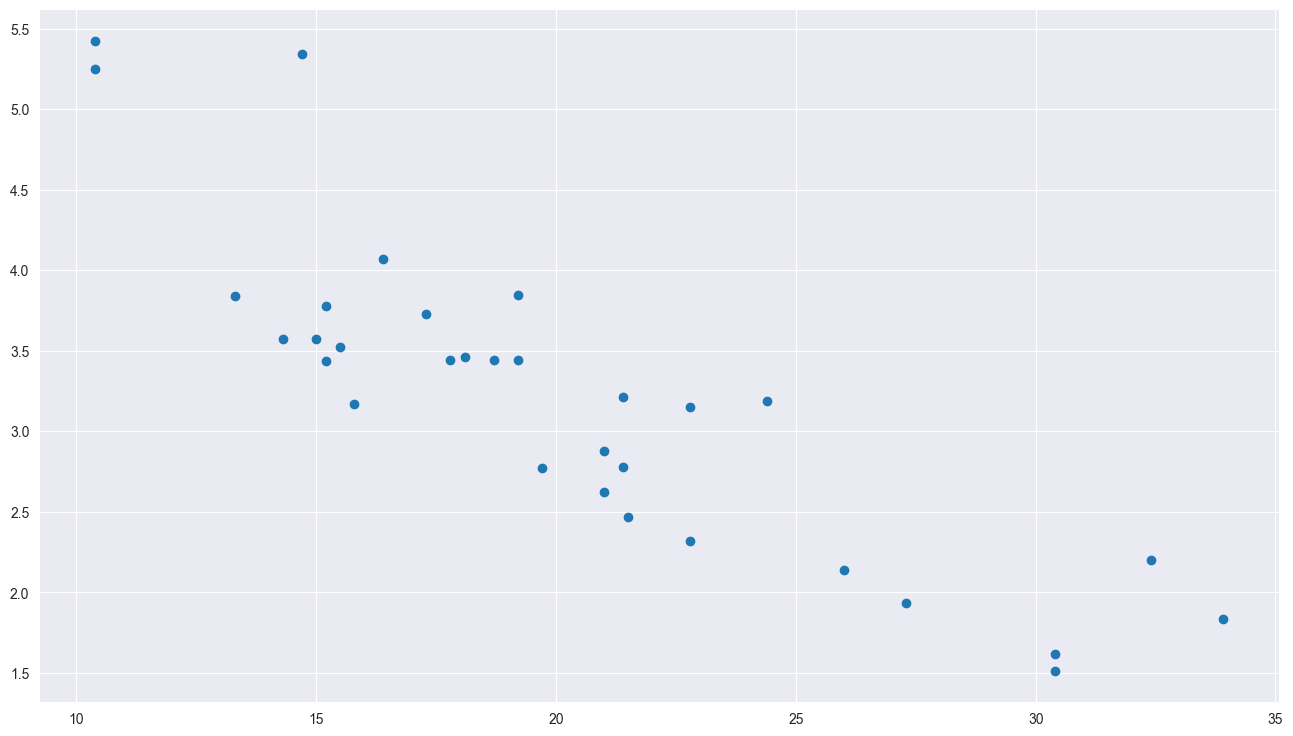

In [291]:
plt.scatter(df['mpg'], df['wt'])
plt.show()

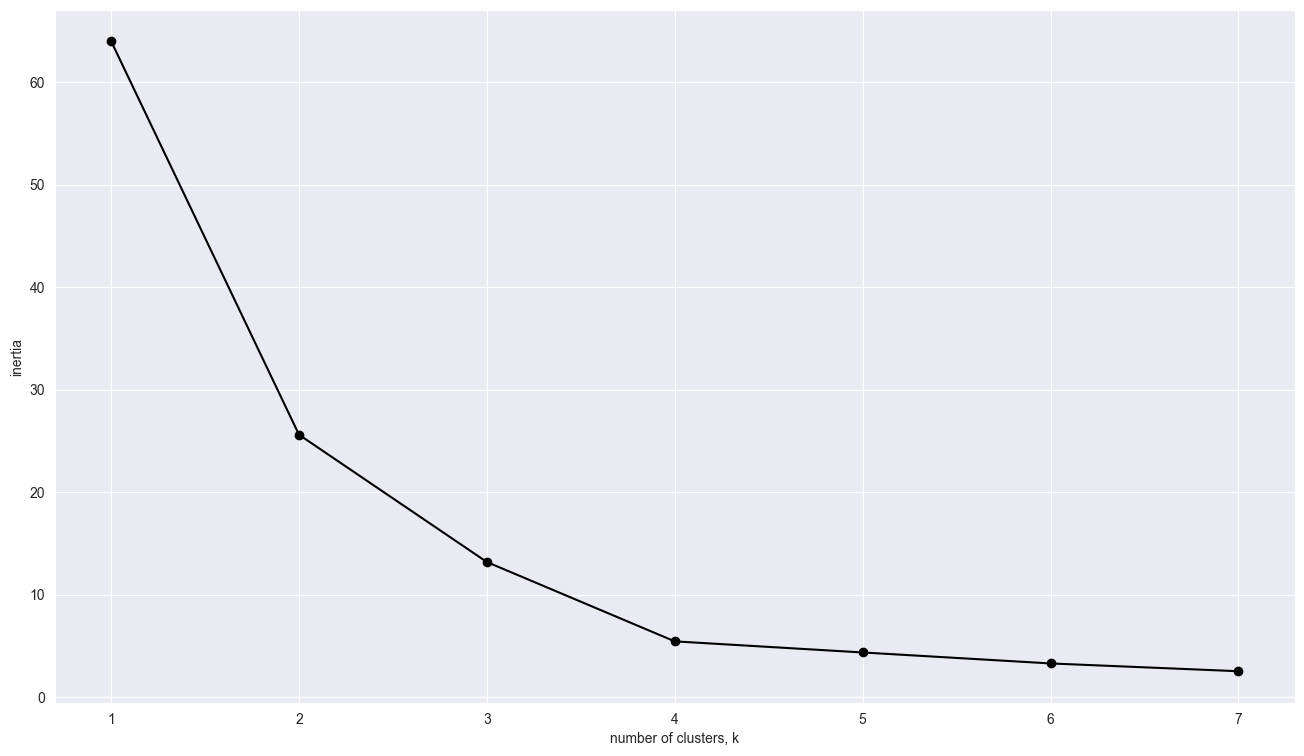

In [292]:
# sklearn kmeans clustering
from sklearn.cluster import KMeans

ks = range(1, 8)
inertia = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(df_escalado_clusters[['mpg', 'wt']])
    
    # Append the inertia to the list of inertias
    inertia.append(model.inertia_)
    
plt.plot(ks, inertia, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [293]:
#Choose k = 3
model = KMeans(n_clusters=4)
model.fit(df_escalado_clusters[['mpg', 'wt']])
df_escalado_clusters['cluster_kmeans'] = model.predict(df_escalado_clusters[['mpg', 'wt']])
df['cluster_kmeans'] = model.predict(df_escalado_clusters[['mpg', 'wt']])

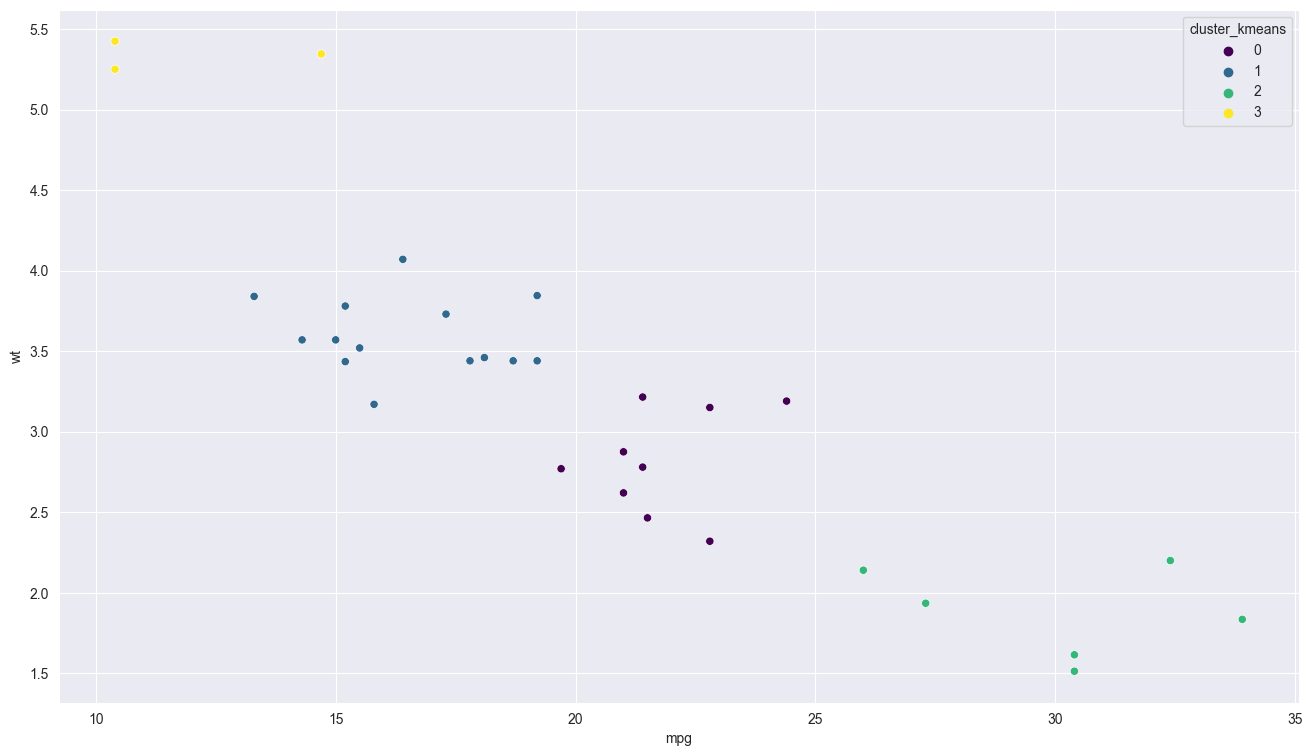

In [294]:
#plot the clusters, with different colors
sns.scatterplot(data=df, x='mpg', y='wt', hue='cluster_kmeans', palette='viridis')
plt.show()

## Hierarchical clustering

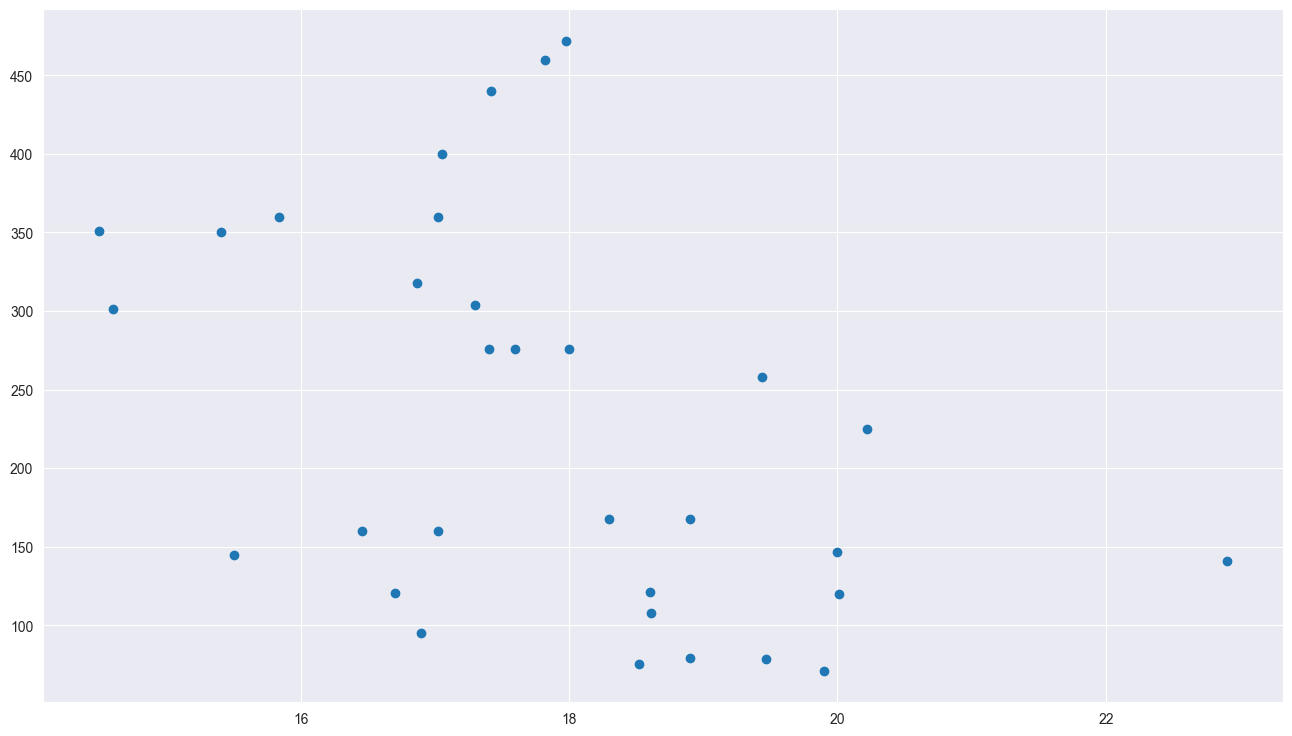

In [295]:
plt.scatter(df['qsec'], df['disp'])
plt.show()

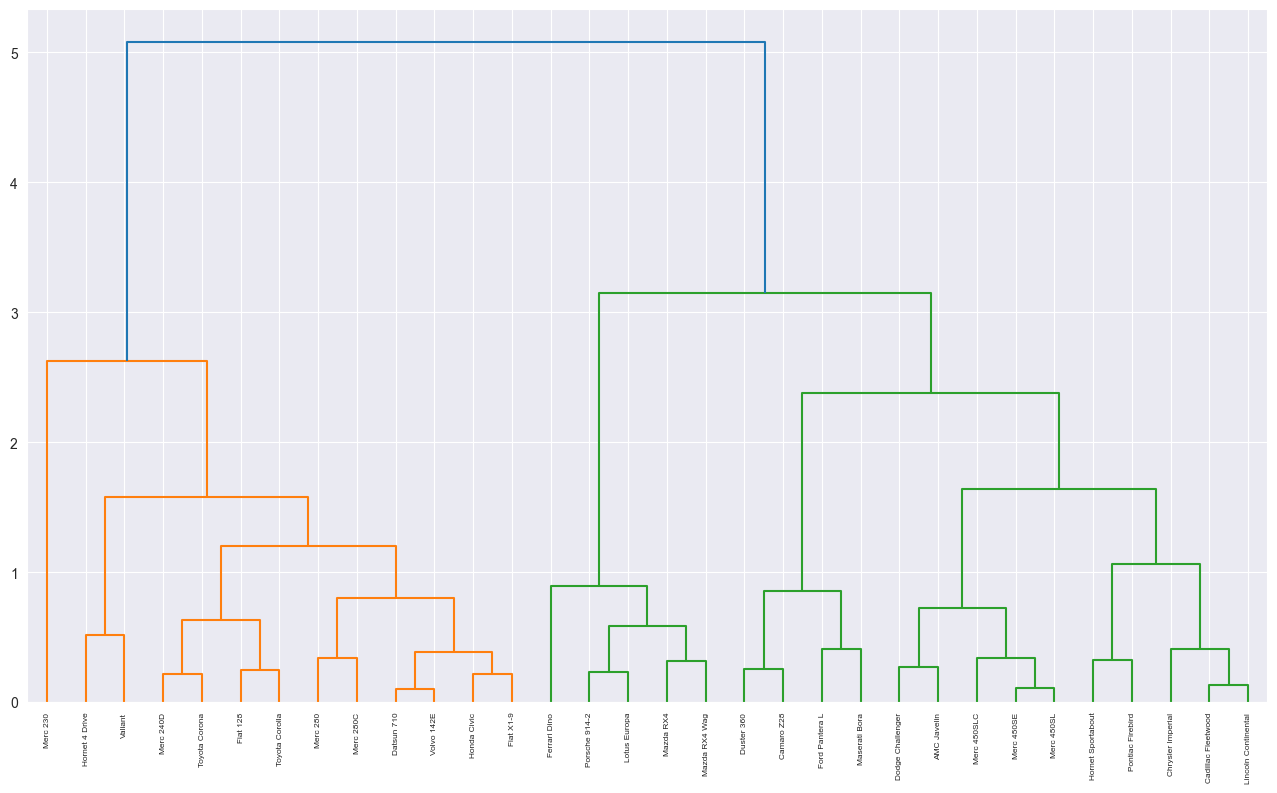

In [296]:
from scipy.cluster.hierarchy import linkage , dendrogram

mergings = linkage(df_escalado_clusters[['qsec', 'disp']], method='complete')
#plot
dendrogram(mergings, labels=df.index, leaf_rotation=90, leaf_font_size=6)
plt.show()

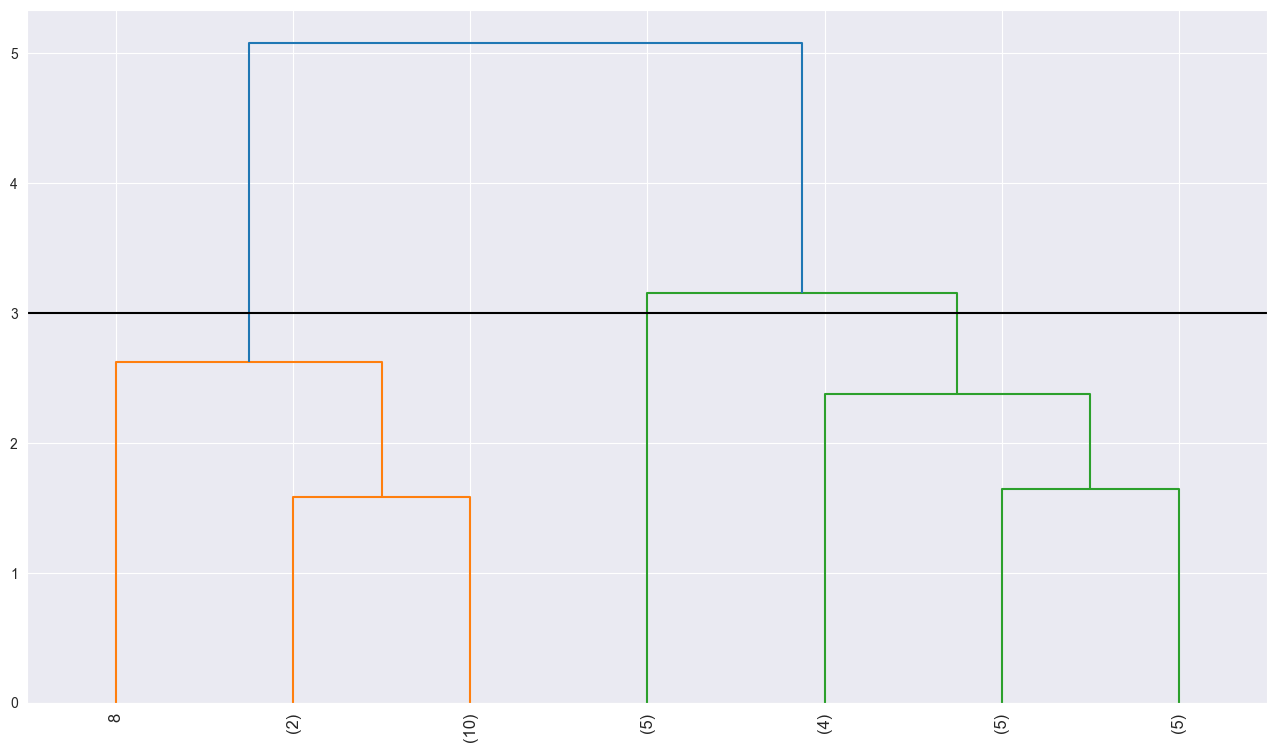

In [297]:
dendrogram(mergings,leaf_rotation=90,
            truncate_mode='lastp',  
            p=7,  
            leaf_font_size=12,
)
plt.axhline(y=3, c='k')

In [298]:
from scipy.cluster.hierarchy import fcluster

# Perform fcluster on the hierarchical clustering
labels = fcluster(mergings, 3, criterion='distance')


In [299]:
df['cluster_jerarquico'] = labels
df_escalado_clusters['cluster_jerarquico'] = labels

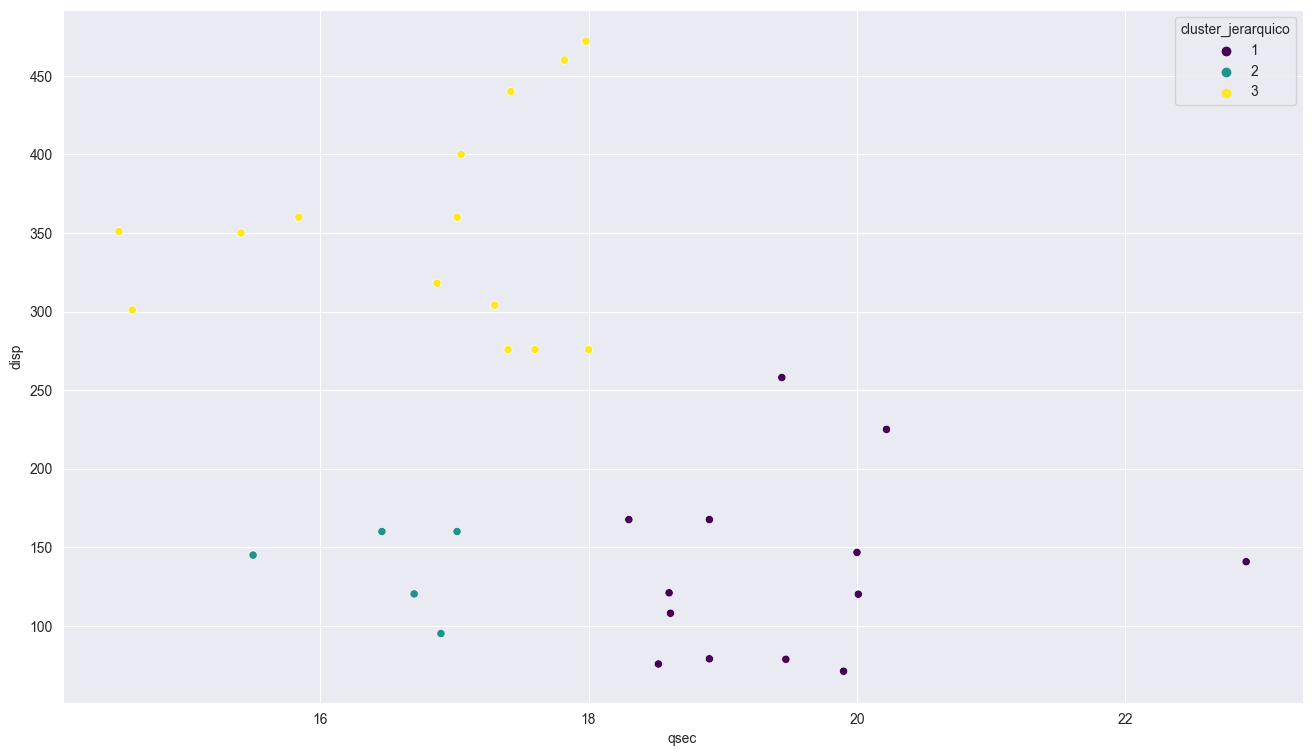

In [300]:
sns.scatterplot(data=df, x='qsec', y='disp', hue='cluster_jerarquico', palette='viridis')
plt.show()

## DBSCAN

In [301]:
df

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb,Random_color,target,Random_Category_CategoryA,Random_Category_CategoryB,Random_Category_CategoryC,cluster_kmeans,cluster_jerarquico
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4,1,0,1.0,0.0,0.0,0,2
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4,1,1,1.0,0.0,0.0,0,2
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1,0,1,0.0,0.0,1.0,0,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1,0,1,0.0,1.0,0.0,0,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2,1,1,1.0,0.0,0.0,1,3
Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1,1,1,0.0,0.0,1.0,1,1
Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4,1,0,1.0,0.0,0.0,1,3
Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2,1,0,1.0,0.0,0.0,0,1
Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2,1,0,0.0,1.0,0.0,0,1
Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4,1,1,0.0,0.0,1.0,1,1


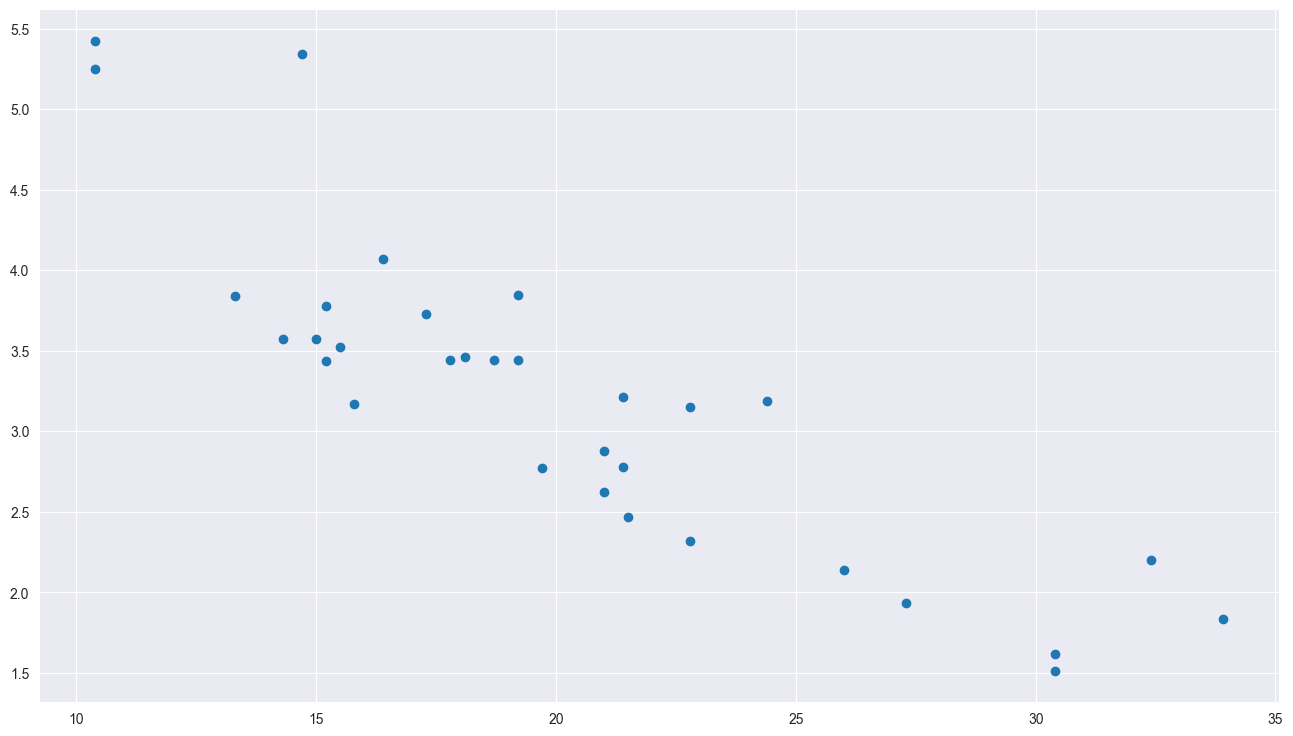

In [302]:
plt.scatter(df['mpg'], df['wt'])
plt.show()

In [303]:
from sklearn.cluster import DBSCAN
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size


db = DBSCAN(eps=0.5, min_samples=5).fit(df_escalado_clusters[['mpg', 'wt']])

In [304]:
df['cluster_dbscan'] = db.labels_
df_escalado_clusters['cluster_dbscan'] = db.labels_

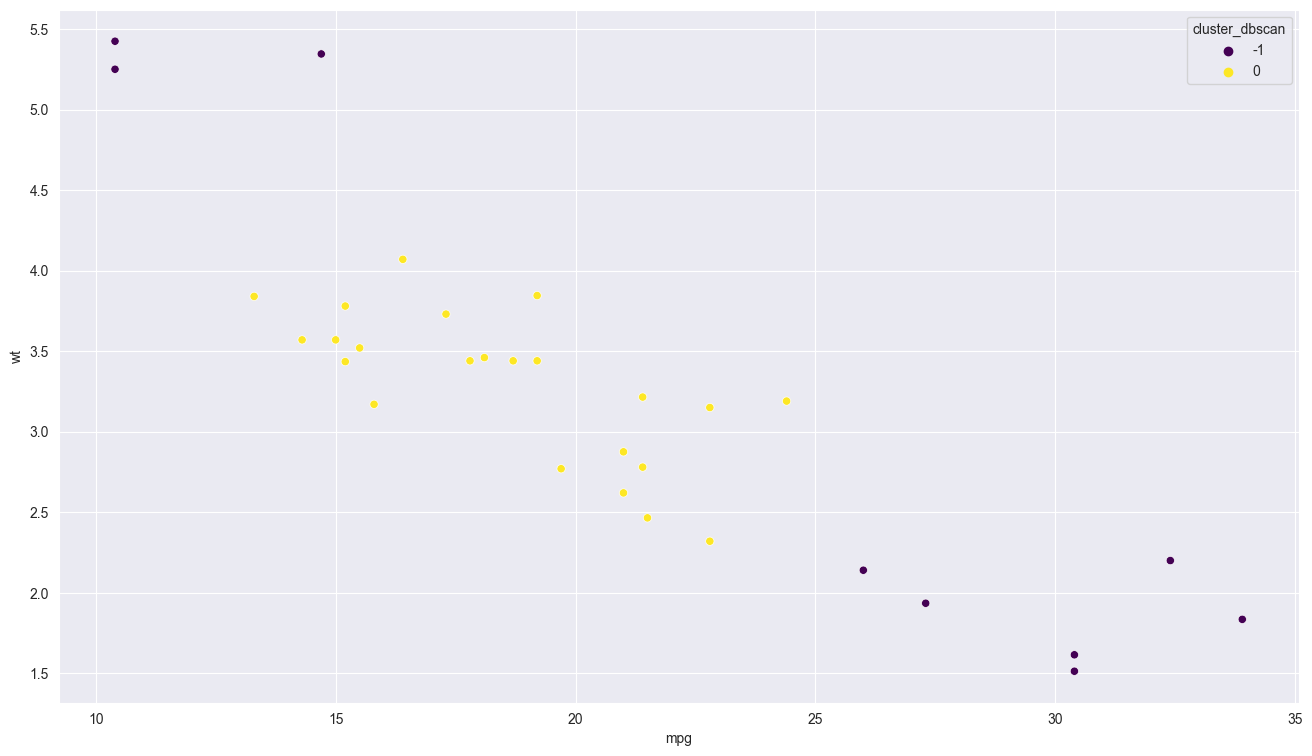

In [305]:
sns.scatterplot(data=df, x='mpg', y='wt', hue='cluster_dbscan', palette='viridis')
plt.show()